#Importing Data


In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [101]:
import plotly.offline as pox
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import StackingClassifier


# Importing Stock Data

In [102]:
Path = 'drive/MyDrive/data/'
AAPL = Path + 'aapl_data.csv'
ABT = Path + 'abt_data.csv'
AMZN = Path + 'amzn_data.csv'
AXP = Path + 'axp_data.csv'
MMM = Path + 'mmm_data.csv'
company_dict = {AAPL: 'AAPL', ABT: 'ABT', AMZN: 'AMZN', AXP: 'AXP', MMM: 'MMM'}


target_company = AAPL

df=pd.read_csv(target_company)
# Filter and remove rows where 'volume' is 0
d = df[df['volume'] == 0]
df = df.drop(d.index, axis=0)

# Convert 'time' to datetime format and extract only the date part
df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.date

# Set the 'time' column as the index
df = df.set_index('time')

# Sort the DataFrame by date
df = df.sort_index(ascending=True)

# Drop the last 16 rows
df.drop(df.tail(16).index, inplace=True)

# Create a copy of the modified DataFrame
next = df.copy()

# Display the tail of the new DataFrame and print "done"
print(next.tail())
print(company_dict[target_company] + " ***DONE***" )

                  open        high         low       close    volume
time                                                                
2024-10-08  224.300003  225.979996  223.250000  225.770004  31855700
2024-10-09  225.229996  229.750000  224.830002  229.539993  33591100
2024-10-10  227.779999  229.500000  227.169998  229.039993  28183500
2024-10-11  229.300003  229.410004  227.339996  227.550003  31759200
2024-10-14  228.699997  231.729996  228.600006  231.300003  39882100
AAPL ***DONE***


# Feature Engineering

In [103]:
# Calculate future returns and signals
df['future_returns'] = df['close'].pct_change().shift(-1)
signal = []
for i in range(len(df)):
    if df['future_returns'].iloc[i] > 0:
        signal.append(1)
    elif df['future_returns'].iloc[i] < 0:
        signal.append(2)
    else:
        signal.append(3)

df['signal'] = signal

# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi'] = calculate_rsi(df['close'], 14)

# Calculate ADX
def calculate_adx(df, period=50):
    high = df['high']
    low = df['low']
    close = df['close']

    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = true_range.rolling(window=period).mean()

    plus_di = 100 * (plus_dm.rolling(window=period).mean() / atr)
    minus_di = 100 * (minus_dm.abs().rolling(window=period).mean() / atr)

    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period).mean()
    return adx

df['adx'] = calculate_adx(df, 50)

# Calculate NATR
def calculate_natr(df, period=50):
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift(1))
    tr3 = abs(df['low'] - df['close'].shift(1))
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = true_range.rolling(window=period).mean()
    natr = (atr / df['close']) * 100
    return natr

df['NATR'] = calculate_natr(df, 50)

# Calculate SMA
df['sma'] = df['close'].rolling(window=30).mean()

# Calculate correlation
df['corr'] = df['close'].rolling(window=int(6.5 * 4)).corr(df['sma'])

# Other features
df['Open-Close'] = (df['open'] - df['close']).shift(-1)
df['Close-High'] = (df['close'] - df['high']).shift(-1)
df['Close-Low'] = (df['close'] - df['low']).shift(-1)

# Drop NaN values
df.dropna(inplace=True)

# Define target and features
y = df[['signal']].copy()
X = df[['rsi', 'adx', 'corr', 'volume', 'Open-Close', 'Close-Low']].copy()

# Correlation Check

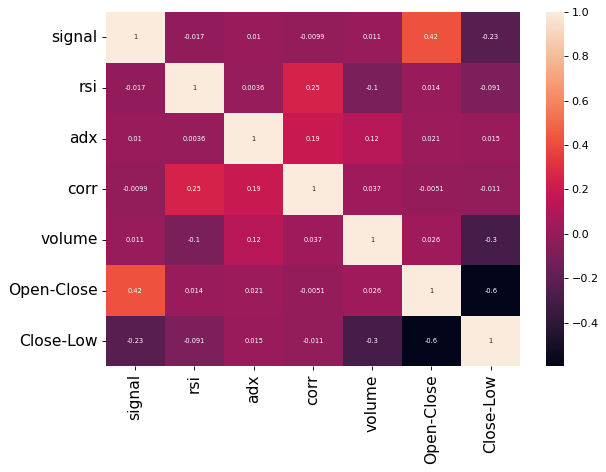

In [104]:
z=df[['signal', 'rsi','adx', 'corr','volume','Open-Close','Close-Low']].copy()
corr = z.corr()
figure(figsize=(8, 6), dpi=80)
sns.heatmap(corr, annot=True, annot_kws = {"size": 6})
plt.yticks(rotation=0, size = 14);
plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

In [105]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns

    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index

print(get_pair_above_threshold(X, 0.7))

MultiIndex([], )


# Stationary Check

In [106]:
def stationary(series):
    """Function to check if the series is stationary or not.
    """
    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'
# Check for stationarity
for col in X.columns:
    if stationary(df[col]) == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)

rsi is stationary.
adx is stationary.
corr is stationary.
volume is stationary.
Open-Close is stationary.
Close-Low is not stationary. Dropping it.


# Splitting and Training Model

In [107]:
split_percentage = 0.8
split = int(split_percentage*len(df))

# Train data set
X_train = X[:split]
y_train = y[:split]
X_test =  X[split:]
y_test =  y[split:]

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

# Initialize and train Decision Tree
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = dt_model.predict(X_test)

Accuracy =accuracy_score(y_test, y_pred)
print(Accuracy)

0.8002283105022832


# confusion Matrix

In [108]:
# Classification report
classification_report_data = classification_report(y_test, y_pred)
# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           1       0.84      0.78      0.81       462
           2       0.77      0.83      0.80       412
           3       0.00      0.00      0.00         2

    accuracy                           0.80       876
   macro avg       0.53      0.54      0.53       876
weighted avg       0.80      0.80      0.80       876



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Making Latest Prediciton

In [109]:
Prediction=model.predict(X)[-1]
if Prediction==1:
    print('Buy')
elif Prediction==2:
    print('Sell')
else:
    print('Hold')
print(Prediction)

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Buy
[1.]


In [110]:
split_percentage = 0.8
split = int(split_percentage*len(df))
temp=pd.DataFrame()
temp['close'] = df.close.iloc[split:]
temp['signal']=np.array(y_pred)
print(temp.tail())

                 close  signal
time                          
2024-10-07  221.690002       2
2024-10-08  225.770004       2
2024-10-09  229.539993       1
2024-10-10  229.039993       2
2024-10-11  227.550003       2


In [111]:
# Variable Required for decision making
buy=[]
sell=[]
profit=[]
Close_profit=[]
Stop_loss=[]
Close_order_buy=[]
Close_order_sell=[]
position_Buy=None
position_Sell=None
profit=0.4
lose=0.4


# Decision Making Process

In [112]:
for i in range(len(temp)):
   #####################################################################################################
    if position_Buy!="Buy"  and position_Sell!="Sell" and Accuracy >0.50 and temp['signal'][i]== 1 :                          #Buy Position
                    buy.append(temp['close'][i])
                    sell.append(np.nan)
                    Close_profit.append(np.nan)
                    Stop_loss.append(np.nan)
                    Close_order_buy.append(temp['close'][i])
                    position_Buy="Buy"
    #############################################################################################
    elif  position_Sell!="Sell"  and position_Buy!="Buy" and Accuracy >0.50 and temp['signal'][i]== 2   :                     #Sell Position
                sell.append(temp['close'][i])
                buy.append(np.nan)
                Close_profit.append(np.nan)
                Stop_loss.append(np.nan)
                Close_order_sell.append(temp['close'][i])
                position_Sell="Sell"

    #################################################################################################
    elif position_Sell=="Sell" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_sell[-1]+lose) <= temp['close'][i]):                   #Take Profit Condition
            Close_profit.append(np.nan)                                        #append to take profit
            Stop_loss.append(temp['close'][i])
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        elif ((Close_order_sell[-1]-(profit)) >= temp['close'][i]):                   #Stop Loss Condition
            Close_profit.append(temp['close'][i])
            Stop_loss.append(np.nan)                                                #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
    ########################################################################################################
    elif position_Buy=="Buy" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_buy[-1]+profit) <= temp['close'][i]):                  #Take Profit Condition
            Close_profit.append(temp['close'][i])                          #append to take profit
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
            position_Buy=None

        elif ((Close_order_buy[-1]-lose) >= temp['close'][i]):                   #Stop Loss Condition
            Close_profit.append(np.nan)
            Stop_loss.append(temp['close'][i])                                  #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            position_Buy=None

        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
#################################################################
    else:
            buy.append(np.nan)
            sell.append(np.nan)
            Stop_loss.append(np.nan)
            Close_profit.append(np.nan)
temp['buy']=buy
temp['sell']=sell
temp['Close_profit']=Close_profit
temp['Stop_loss']=Stop_loss
print((temp[temp['buy']!=np.nan]).count())
print(f"Profitibily { temp['Close_profit'].count()/(temp['Close_profit'].count()+temp['Stop_loss'].count())}")


close           876
signal          876
buy             200
sell            205
Close_profit    328
Stop_loss        76
dtype: int64
Profitibily 0.8118811881188119


<ipython-input-112-708f1d65bd04>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-112-708f1d65bd04>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-112-708f1d65bd04>:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-112-708f1d65bd04>:16: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

# Plotting

In [113]:
symb = company_dict[target_company] + " RF + XGBC"
# trace1=go.Candlestick(
# x=df.index,
# low=df['low'],
# close=df['close'],
# open=df['open'],
# high=df['high'],
# increasing_line_color='green',
# decreasing_line_color='red',
# name='USD/EUR',
# )
trace1=go.Scatter(
    y=temp.close,
    mode='lines',
    name='Close_price'
)

trace4=go.Scatter(

    y=temp['buy'],
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='triangle-up' ),
    name='buy'
    )
trace5=go.Scatter(

    y=temp.sell,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='triangle-down'),
    name='sell')
trace6=go.Scatter(

    y=temp.Close_profit,
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='cross'),
    name='Profit')
trace7=go.Scatter(

    y=temp.Stop_loss,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='cross'),
    name='Loss')

data=[trace1,trace4,trace5,trace6,trace7]
layout=go.Layout(
    title=symb,
    yaxis=dict(title='Assest value'),
    xaxis=dict(title='Time And date'))
figure=go.Figure(data=data,layout=layout)
figure.update_layout(xaxis_rangeslider_visible=False)
pox.plot(figure)


'temp-plot.html'